# Horse vs Humans

In [1]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [3]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O ./tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = './tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

--2021-11-02 18:50:36--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.136.128, 209.85.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   205MB/s    in 0.4s    

2021-11-02 18:50:36 (205 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0               

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

last layer output shape:  (None, 7, 7, 768)


In [5]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        thres = 0.999
        if(logs.get('accuracy') is not None and logs.get('accuracy') >= thres) : # Experiment with changing this value
            print(f"\nReached {thres*100}% accuracy on epoch = {epoch+1}!")
            self.model.stop_training = True

In [6]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
# Get the Horse or Human dataset
!gdown --id 1onaG42NZft3wCE1WH0GDEbUhu75fedP5

# Get the Horse or Human Validation dataset
!gdown --id 1LYeusSEIiZQpwN-mthh5nKdA75VsKG1U
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./training')
zip_ref.close()

local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./validation')
zip_ref.close()


# Define our example directories and files
train_dir = './training'
validation_dir = './validation'

Downloading...
From: https://drive.google.com/uc?id=1onaG42NZft3wCE1WH0GDEbUhu75fedP5
To: /content/horse-or-human.zip
100% 150M/150M [00:00<00:00, 172MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LYeusSEIiZQpwN-mthh5nKdA75VsKG1U
To: /content/validation-horse-or-human.zip
100% 11.5M/11.5M [00:00<00:00, 101MB/s]


In [8]:
train_horses_dir = train_dir + '/horses'
train_humans_dir = train_dir + '/humans'
validation_horses_dir = validation_dir + '/horses'
validation_humans_dir = validation_dir + '/humans'

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [9]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
                        rescale=1./255,
                        rotation_range = 40,
                        width_shift_range = 0.2,
                        height_shift_range = 0.2,
                        shear_range = 0.2,
                        zoom_range = 0.2,
                        horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size=20, 
                                                    class_mode='binary', 
                                                    target_size=(150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20, 
                                                         class_mode='binary', 
                                                         target_size=(150, 150))

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [10]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy

callbacks = myCallback()
history = model.fit(train_generator,
                              validation_data = validation_generator,
                              epochs = 100,
                              callbacks = [callbacks],
                              verbose = 2)

Epoch 1/100
52/52 - 48s - loss: 0.1465 - accuracy: 0.9445 - val_loss: 0.0642 - val_accuracy: 0.9766
Epoch 2/100
52/52 - 13s - loss: 0.0234 - accuracy: 0.9903 - val_loss: 0.0635 - val_accuracy: 0.9844
Epoch 3/100
52/52 - 13s - loss: 0.0233 - accuracy: 0.9912 - val_loss: 0.0483 - val_accuracy: 0.9883
Epoch 4/100
52/52 - 13s - loss: 0.0166 - accuracy: 0.9932 - val_loss: 0.1682 - val_accuracy: 0.9609
Epoch 5/100
52/52 - 14s - loss: 0.0228 - accuracy: 0.9942 - val_loss: 0.0260 - val_accuracy: 0.9922
Epoch 6/100
52/52 - 13s - loss: 0.0131 - accuracy: 0.9951 - val_loss: 2.2293e-04 - val_accuracy: 1.0000
Epoch 7/100
52/52 - 13s - loss: 0.0190 - accuracy: 0.9951 - val_loss: 0.0365 - val_accuracy: 0.9766
Epoch 8/100
52/52 - 13s - loss: 0.0102 - accuracy: 0.9961 - val_loss: 1.1087e-05 - val_accuracy: 1.0000
Epoch 9/100
52/52 - 13s - loss: 0.0057 - accuracy: 0.9981 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 10/100
52/52 - 13s - loss: 0.0084 - accuracy: 0.9971 - val_loss: 0.0297 - val_accuracy

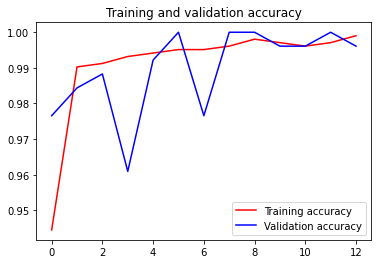

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()